In [36]:
import os
import random
import shutil
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import torch
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import cv2


Epoch [1/80], Loss: 3.4658
Epoch [2/80], Loss: 2.2820
Epoch [3/80], Loss: 1.9134
Epoch [4/80], Loss: 1.6809
Epoch [5/80], Loss: 1.5267
Epoch [6/80], Loss: 1.3106
Epoch [7/80], Loss: 1.1901
Epoch [8/80], Loss: 1.1296
Epoch [9/80], Loss: 1.0029
Epoch [10/80], Loss: 0.9356
Epoch [11/80], Loss: 0.9206
Epoch [12/80], Loss: 0.8913
Epoch [13/80], Loss: 0.8459
Epoch [14/80], Loss: 0.7701
Epoch [15/80], Loss: 0.7448
Epoch [16/80], Loss: 0.6863
Epoch [17/80], Loss: 0.6613
Epoch [18/80], Loss: 0.6267
Epoch [19/80], Loss: 0.6064
Epoch [20/80], Loss: 0.5834
Epoch [21/80], Loss: 0.5481
Epoch [22/80], Loss: 0.5260
Epoch [23/80], Loss: 0.5012
Epoch [24/80], Loss: 0.4860
Epoch [25/80], Loss: 0.4714
Epoch [26/80], Loss: 0.4626
Epoch [27/80], Loss: 0.4528
Epoch [28/80], Loss: 0.4351
Epoch [29/80], Loss: 0.4328
Epoch [30/80], Loss: 0.4257
Epoch [31/80], Loss: 0.4124
Epoch [32/80], Loss: 0.3787
Epoch [33/80], Loss: 0.3731
Epoch [34/80], Loss: 0.3582
Epoch [35/80], Loss: 0.3608
Epoch [36/80], Loss: 0.3417
E

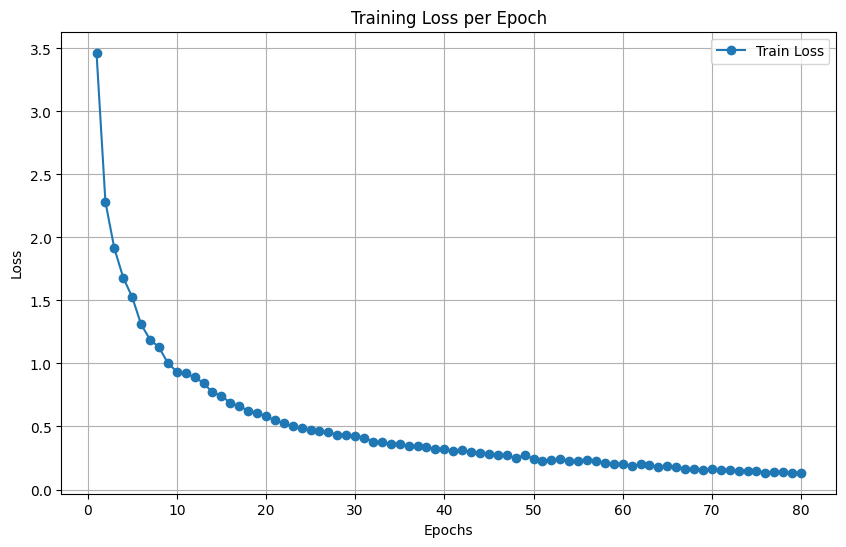

Model is not overfitting. Loss is decreasing consistently.


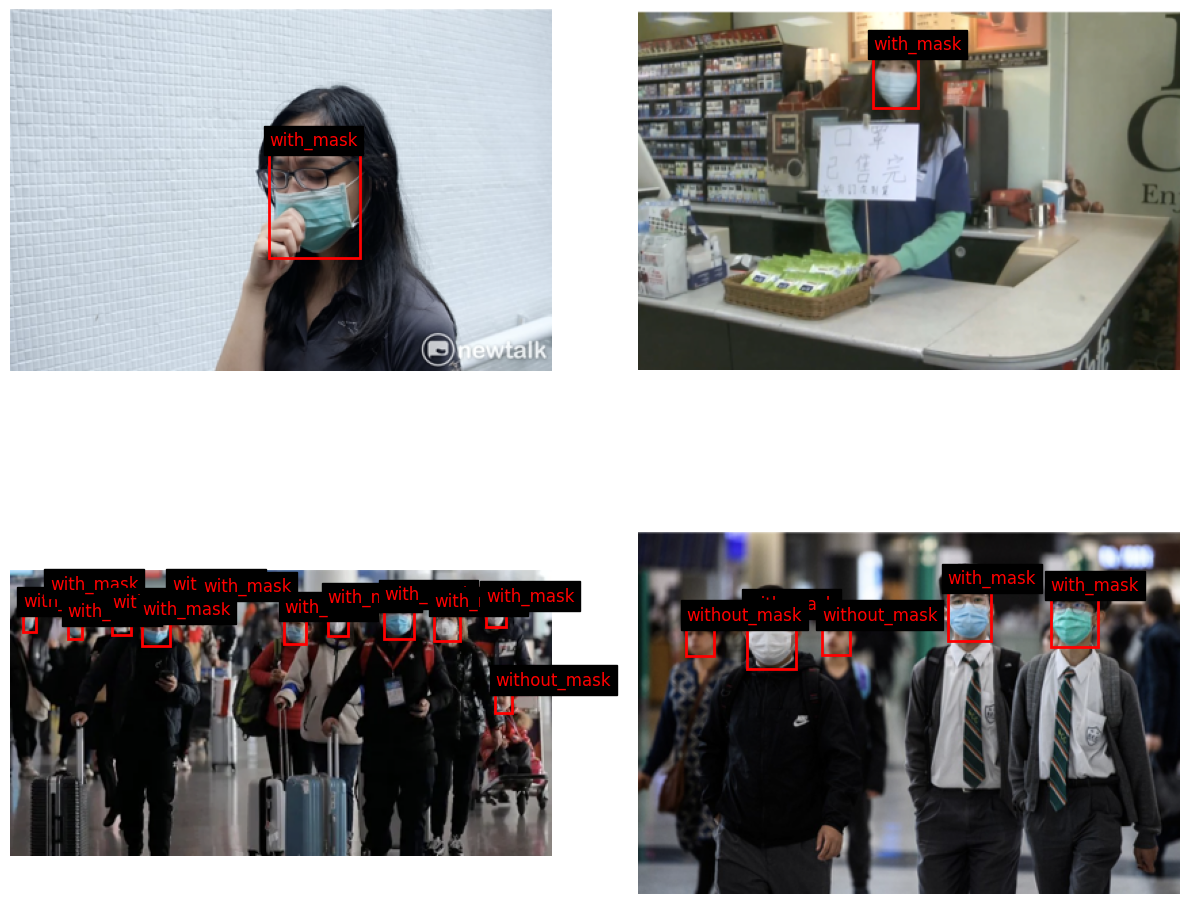

In [37]:


# Paths
DATASET_DIR = "/kaggle/input/face-mask-detection"
IMAGE_DIR = os.path.join(DATASET_DIR, "images")
ANNOTATION_DIR = os.path.join(DATASET_DIR, "annotations")
OUTPUT_DIR = "/kaggle/working/datasets"

# Class Mapping
CLASS_ID = {"with_mask": 0, "mask_weared_incorrect": 1, "without_mask": 2}

# Parse Annotations
def parse_annotations(annotation_dir):
    data = []
    for annotation_path in glob.glob(os.path.join(annotation_dir, '*.xml')):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        filename = root.find('filename').text
        size = root.find('size')
        width, height = int(size.find('width').text), int(size.find('height').text)

        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = [
                int(obj.find("bndbox/xmin").text),
                int(obj.find("bndbox/ymin").text),
                int(obj.find("bndbox/xmax").text),
                int(obj.find("bndbox/ymax").text)
            ]
            data.append({
                "filename": filename,
                "label": label,
                "class_id": CLASS_ID[label],
                "width": width,
                "height": height,
                "bboxes": bbox
            })
    return pd.DataFrame(data)

# Split Dataset
def split_dataset(df, test_size=0.2, val_size=0.15, random_state=42):
    train_files, test_files = train_test_split(df['filename'].unique(), test_size=test_size, random_state=random_state)
    train_files, val_files = train_test_split(train_files, test_size=val_size, random_state=random_state)
    return train_files, val_files, test_files

# Setup Directories
def setup_directories(output_dir):
    paths = {"train": os.path.join(output_dir, "train"),
             "valid": os.path.join(output_dir, "valid"),
             "test": os.path.join(output_dir, "test")}
    for path in paths.values():
        os.makedirs(path, exist_ok=True)
    return paths

# Copy Images and Create Labels
def copy_and_label_images(files, df, src_dir, dest_dir):
    for file in files:
        shutil.copy(os.path.join(src_dir, file), dest_dir)
        label_path = os.path.join(dest_dir, os.path.splitext(file)[0] + '.txt')
        with open(label_path, 'w') as f:
            for _, row in df[df['filename'] == file].iterrows():
                bbox = row['bboxes']
                f.write(f"{row['class_id']} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

# Dataset Class
class FaceMaskDataset(Dataset):
    def __init__(self, df, folder_path, transform=None):
        self.df = df
        self.folder_path = folder_path
        self.image_files = df['filename'].unique()
        self.transform = transform or transforms.Compose([
            transforms.Resize((400, 400)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        file = self.image_files[idx]
        img_path = os.path.join(self.folder_path, file)
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        data = self.df[self.df['filename'] == file]
        boxes = torch.tensor(data['bboxes'].tolist(), dtype=torch.float32)
        labels = torch.tensor(data['class_id'].tolist(), dtype=torch.int64)

        return img, boxes, labels

# Visualization
def visualize_samples(df, folder_path):
    files = random.sample(list(df['filename'].unique()), 4)
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    for ax, file in zip(axs.flatten(), files):
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path)
        ax.imshow(img)
        for _, row in df[df['filename'] == file].iterrows():
            bbox = row['bboxes']
            label = row['label']
            ax.add_patch(Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                                    linewidth=2, edgecolor='r', facecolor='none'))
            ax.text(bbox[0], bbox[1] - 5, label, color='red', fontsize=12, backgroundcolor='black')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Training Loop
def train_model(model, optimizer, train_loader, num_epochs, device):
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for images, boxes, labels in train_loader:
            images = [img.to(device) for img in images]
            targets = [{"boxes": box.to(device), "labels": label.to(device)} for box, label in zip(boxes, labels)]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()

        train_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]:.4f}")

    # Save the model
    torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "ssd_face_mask_detector.pth"))

    # Plot the losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Check for overfitting
    if len(train_losses) > 1 and train_losses[-1] > train_losses[-2]:
        print("Model might be overfitting. The loss increased in the last epoch.")
    else:
        print("Model is not overfitting. Loss is decreasing consistently.")

# Main Workflow
df = parse_annotations(ANNOTATION_DIR)
train_files, val_files, test_files = split_dataset(df)
paths = setup_directories(OUTPUT_DIR)
copy_and_label_images(train_files, df, IMAGE_DIR, paths['train'])
copy_and_label_images(val_files, df, IMAGE_DIR, paths['valid'])
copy_and_label_images(test_files, df, IMAGE_DIR, paths['test'])

# Dataset and Dataloader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = FaceMaskDataset(df[df['filename'].isin(train_files)], paths['train'])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Model Setup
model = ssdlite320_mobilenet_v3_large(pretrained=True)
model.num_classes = len(CLASS_ID)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Train Model
train_model(model, optimizer, train_loader, num_epochs=80, device=device)

# Visualize Samples
visualize_samples(df, paths['train'])
